In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
train_dataset = torchvision.datasets.FashionMNIST(root='.',
                                                    train=True,
                                                    transform=transforms.ToTensor(),
                                                    download=True)

26422272it [00:05, 4902090.53it/s]                              


Extracting .\FashionMNIST\raw\train-images-idx3-ubyte.gz to .\FashionMNIST\raw



29696it [00:00, 203393.07it/s]                          


Extracting .\FashionMNIST\raw\train-labels-idx1-ubyte.gz to .\FashionMNIST\raw



4422656it [00:02, 1590871.74it/s]                             


Extracting .\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to .\FashionMNIST\raw



6144it [00:00, ?it/s]                   

Extracting .\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to .\FashionMNIST\raw



In [3]:
train_dataset.data.max()

tensor(255, dtype=torch.uint8)

In [4]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [5]:
train_dataset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [6]:
test_dataset = torchvision.datasets.FashionMNIST(root='.',
                                                   train=False,
                                                   transform=transforms.ToTensor(),
                                                   download=False)

In [7]:
K = len(set(train_dataset.targets.numpy()))
print("number of classes", K)

number of classes 10


In [8]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2),
            nn.ReLU()
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(128*2*2, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, K)
        )

    def forward(self, X):
        out = self.conv_layers(X)
        out = out.view(out.size(0), -1)
        out = self.dense_layers(out)
        return out

In [9]:
model = CNN(K)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [12]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                             batch_size=batch_size,
                                             shuffle=True)   

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=batch_size,
                                            shuffle=False)

In [13]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        train_loss = np.mean(train_loss)

        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}')

    return train_losses, test_losses

In [14]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=15)

Epoch 1/15, Train Loss: 0.6498, Test Loss: 0.4797, Duration: 0:00:15.973069
Epoch 2/15, Train Loss: 0.4391, Test Loss: 0.4073, Duration: 0:00:16.402717
Epoch 3/15, Train Loss: 0.3770, Test Loss: 0.3782, Duration: 0:00:16.091838
Epoch 4/15, Train Loss: 0.3405, Test Loss: 0.3413, Duration: 0:00:15.813721
Epoch 5/15, Train Loss: 0.3136, Test Loss: 0.3159, Duration: 0:00:15.769959
Epoch 6/15, Train Loss: 0.2914, Test Loss: 0.3070, Duration: 0:00:16.272668
Epoch 7/15, Train Loss: 0.2722, Test Loss: 0.2979, Duration: 0:00:15.910539
Epoch 8/15, Train Loss: 0.2551, Test Loss: 0.2864, Duration: 0:00:15.962711
Epoch 9/15, Train Loss: 0.2385, Test Loss: 0.2905, Duration: 0:00:16.158904
Epoch 10/15, Train Loss: 0.2271, Test Loss: 0.2854, Duration: 0:00:16.546768
Epoch 11/15, Train Loss: 0.2133, Test Loss: 0.2859, Duration: 0:00:16.092000
Epoch 12/15, Train Loss: 0.2012, Test Loss: 0.2799, Duration: 0:00:16.110215
Epoch 13/15, Train Loss: 0.1878, Test Loss: 0.2911, Duration: 0:00:16.169000
Epoch 14

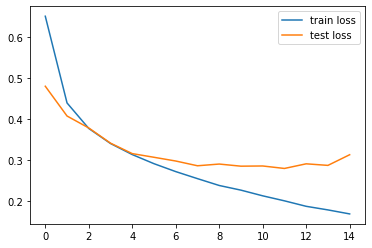

In [15]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [16]:
model.eval()
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_acc = n_correct/n_total

n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct/n_total
print(f'Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}')

Train acc: 0.9441, Test acc: 0.8970


In [17]:
import sklearn.metrics as confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')
    
        print(cm)
    
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
    
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

Confusion matrix, without normalization
[[904   0  29  23   3   1  35   0   5   0]
 [  3 977   1  14   1   0   2   0   2   0]
 [ 15   1 906  10  48   0  20   0   0   0]
 [ 15   9  23 905  37   0  11   0   0   0]
 [  1   1  72  19 882   0  24   0   1   0]
 [  1   0   0   0   0 980   0  12   0   7]
 [160   1 119  29 156   1 530   0   4   0]
 [  0   0   0   0   0  17   0 950   0  33]
 [  1   2   8   2   4   2   8   1 971   1]
 [  1   0   0   0   0   6   0  27   1 965]]


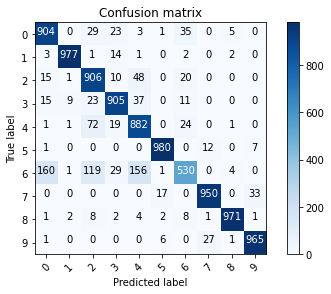

In [18]:
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix.confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [19]:
labels = '''T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot'''.split("\n")

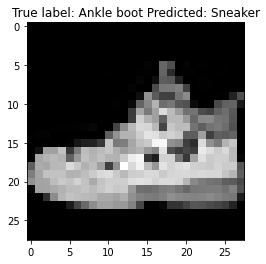

In [40]:
p_test = p_test.astype(np.uint8)
missclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(missclassified_idx)
plt.imshow(x_test[i].reshape(28,28), cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));